In [1]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture import BayesianGaussianMixture as BGMM
import warnings
import seaborn as sns
#import pygmmis
from my_gmm import my_GMM, estimate_MI_single_posterior_sample, consistent, bootstrap_multiprocessing
#from multiprocess import set_start_method
# https://pythonspeed.com/articles/python-multiprocessing/
#set_start_method("fork") # 'fork' seems to get deadlocked, 'spawn' is a bit slower but works
#from multiprocess import Pool
from functools import partial
from sklearn.feature_selection import mutual_info_regression
import gc
import time
from scipy.stats import multivariate_normal
from scipy.stats import chi2 as chisquare

from matplotlib.patches import Ellipse
import pandas as pd

from sklearn.utils import check_random_state
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

import pygmmis
from scipy import integrate

import numbers

In [2]:
def draw_ellipse_fitted(position, covariance, weight, ax=None, alpha=None, color=None, label=None, count=0, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
        #print(s)
        
    # Draw the Ellipse
    # These should be 68% and 95% contours, from a chi2 table
    ranges = [np.sqrt(5.991)] #[np.sqrt(0.77), np.sqrt(5.991)]
    for nsig in ranges:
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, color=color, alpha=alpha, label=label if count==0 else "", **kwargs))
    ax.scatter(position[0], position[1],  marker='X', s=2000*weight, color=color, alpha=alpha, )
    ax.legend(fontsize=30, frameon=False)#, loc='upper left')
    
def draw_ellipse_gt(position, covariance, weight, ax=None, alpha=None, color=None, label=None, count=0, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
        #print(s)
        
    # Draw the Ellipse
    # These should be 68% and 95% contours, from a chi2 table
    ranges = [np.sqrt(5.991)] #[np.sqrt(0.77), np.sqrt(5.991)]
    for nsig in ranges:
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, color=color, alpha=alpha,  label=label if count==0 else "", **kwargs))
    ax.scatter(position[0], position[1],  marker='X', s=2000*weight, color=color, alpha=alpha)
    ax.legend(fontsize=32, frameon=False)#, loc='upper left')
    
        
def plot_covariance(means, covariances, weights, means_fitted, covariances_fitted, weights_fitted,  ax=None, bf=False):
    ax = ax or plt.gca()
    #ax.set_xlim((-4, 5))
    #ax.set_ylim((-2.1, 4.5))
    
    w_factor = 1 # just for the plot
    count=0
    for mean, covariance, weight in zip(means, covariances, weights):
        #if weight < 0.19:
        #    count += 1
        #    continue
        draw_ellipse_gt(mean, covariance, weight, ax=ax, alpha=0.2, fill=True, color='grey', linewidth=4, label='Ground truth', count=count)
        count += 1

    count=0
    for i, (mean_fitted, covariance_fitted, weight_fitted) in enumerate(zip(means_fitted, covariances_fitted, weights_fitted)):
        #if weight_fitted < 0.2:
            #count += 1
        #    continue
        if bf:
            draw_ellipse_fitted(mean_fitted, covariance_fitted, weight_fitted, ax=ax, alpha=w_factor, fill=False, color='darkblue', linewidth=3, label='Bad fit (BF)', count=count)
        else:
            draw_ellipse_fitted(mean_fitted, covariance_fitted, weight_fitted, ax=ax, alpha=w_factor, fill=False, color='darkblue', linewidth=3, label='Fitted model', count=count)

        count += 1
    

In [3]:
# here we define a custom model for a fixed gmm with known parameters
class FixedParMixture_:
    """ A model to estimate gaussian mixture with fixed parameters matrix. 
        This is only needed to estimate its log-likelihood, not to sample from it
        Note this is only for a 1D GMM, as in n_features=1! 
    """
    def __init__(self, n_components, mean, cov, weight):
        self.n_components = n_components
        self.mean = mean
        self.cov = cov
        self.w = weight

    
    def estimate_prob(self, X):
        marginal = 0
        for i in range(self.n_components):
            mu = self.mean[i]
            sigma = self.cov[i]
            w = self.w[i]
            marginal += w*multivariate_normal.pdf(x=np.array([X]).T, mean=np.array([mu]), cov=np.array([sigma]))         
        return marginal
        
    
    def score_samples(self, X):
        """Compute the log-likelihood of each sample.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log-likelihood of each sample in `X` under the current model.
            
        This is taken from the sklearn source code
        """

        return np.log(self.estimate_prob(X))

def marginal_loglike_(gmm, points, n_components, i):
    # i = 0 is x
    # i = 1 is y
    ll = FixedParMixture_(n_components, gmm.means_[:, i], gmm.covariances_[:, i, i], gmm.weights_).score_samples(points[:, i])
    return ll


In [4]:
# three different models, chosen based on the number of components
n_components = 6

# fix random state for stability across runs
random_state = 13

if n_components == 1:
    weights = np.array([1.0])
    mu0, mu1, mu2 = [-1, 1], [0, 2], [-1.5, 2]
    means = np.array([mu0])
    C0, C1, C2 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]]
    covariances = np.array([C1])
    gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=random_state)
elif n_components == 2:
    weights = np.array([0.96, 0.04])
    mu0, mu1 = [0, 0], [1, 1]
    means = np.array([mu0, mu1])
    C0, C1 = [[1, 0], [0, 1]], [[0.1, 0.], [0., 0.1]]
    covariances = np.array([C0, C1])
    gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=random_state)
elif n_components == 3:
    weights = np.array([0.3, 0.45, 0.25])
    mu0, mu1, mu2 = [-1, 1], [0, 2], [-1.5, 2]
    means = np.array([mu0, mu1, mu2])
    C0, C1, C2 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]]
    covariances = np.array([C0, C1, C2])
    gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=random_state)
elif n_components == 5:
    weights = np.array([0.2, 0.35, 0.15, 0.12, 0.18])
    mu0, mu1, mu2, mu3, mu4 = [-1, 1], [0, 2], [-1.5, 2], [2, 1], [-0.25, 0]
    means = np.array([mu0, mu1, mu2, mu3, mu4])
    C0, C1, C2, C3, C4 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]], [[0.5, -0.1], [-0.1, 0.9]], [[0.2, -0.05], [-0.05, 0.1]]
    covariances = np.array([C0, C1, C2, C3, C4])
    gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=random_state)
elif n_components == 6:
    # this is for D5'
    n_components = 5
    weights = np.array([0.2, 0.35, 0.15, 0.12, 0.18])
    mu0, mu1, mu2, mu3, mu4 = [-1, 1], [0, 2], [-1.5, 2], [3, 1], [-0.25, 0]
    means = np.array([mu0, mu1, mu2, mu3, mu4])
    C0, C1, C2, C3, C4 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]], [[0.5, -0.1], [-0.1, 0.9]], [[0.2, -0.05], [-0.05, 0.1]]
    covariances = np.array([C0, C1, C2, C3, C4])
    gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=random_state)

### Proposed procedure

In [5]:
n_inits = 10
n_folds = 5
N = int(1e4)
data_each_fold = N // n_folds
tol = 1e-6
reg_covar = 1e-6
val_scores_seeds = np.zeros(n_inits)

In [6]:
def check_random_state(seed):
    """Turn seed into a np.random.RandomState instance
    Parameters
    ----------
    seed : None, int or instance of RandomState
        If seed is None, return the RandomState singleton used by np.random.
        If seed is an int, return a new RandomState instance seeded with seed.
        If seed is already a RandomState instance, return it.
        Otherwise raise ValueError.
    """
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, numbers.Integral):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError(
        "%r cannot be used to seed a numpy.random.RandomState instance" % seed
    )

def estimate_gaussian_covariances_full(resp, X, nk, means, reg_covar):
    """Estimate the full covariance matrices.
    Parameters
    ----------
    resp : array-like of shape (n_samples, n_components)
    X : array-like of shape (n_samples, n_features)
    nk : array-like of shape (n_components,)
    means : array-like of shape (n_components, n_features)
    reg_covar : float
    Returns
    -------
    covariances : array, shape (n_components, n_features, n_features)
        The covariance matrix of the current components.
    """
    n_components, n_features = means.shape
    covariances = np.empty((n_components, n_features, n_features))
    for k in range(n_components):
        diff = X - means[k]
        covariances[k] = np.dot(resp[:, k] * diff.T, diff) / nk[k]
        covariances[k].flat[:: n_features + 1] += reg_covar
    return covariances
    
def initialize_parameters(X, random_state, reg_covar=reg_covar, n_components=n_components, init_type='random'):
    """Initialize the model parameters.
    Parameters
    ----------
    X : array-like of shape  (n_samples, n_features)
    random_state : RandomState
        A random number generator instance that controls the random seed
        used for the method chosen to initialize the parameters.
    """
    n_samples, _ = X.shape

    random_state = check_random_state(random_state)
    
    if init_type == "random":
        resp = random_state.rand(n_samples, n_components)
        resp /= resp.sum(axis=1)[:, np.newaxis]
        
    else:
        print('Error: initalisation type not specified or not known')
        
    nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
    weights = nk/n_samples
    means = np.dot(resp.T, X) / nk[:, np.newaxis]
    
    covariances = estimate_gaussian_covariances_full(resp, X, nk, means, reg_covar)
    precisions = np.empty_like(covariances)
    
    for i in range(n_components):
        precisions[i] = np.linalg.inv(covariances[i])
        
    return weights, means, covariances, precisions


In [82]:
X_all = np.zeros((n_folds, data_each_fold, 2))

# first, sample training and validation data
# this is a mixture of training and validation, since we do m-fold CV
for i in range(n_folds):
    gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=i+5)
    X_all[i] = gmm_true.sample(data_each_fold)[0]

X_all_flat = np.reshape(X_all, (-1, 2))
# number of components is fixed to the true number

# fix the random seed first
for r, init in enumerate(range(n_inits)):

    print()  
    w_init, m_init, c_init, p_init = initialize_parameters(X_all_flat, r)
    validation_scores = []
    for fold in range(n_folds):
        X_validation = X_all[fold].reshape(data_each_fold, 2)
        X_training = X_all[np.arange(len(X_all))!=fold].reshape(-1, 2)
        
        fitted_gmm = GMM(n_components=n_components, reg_covar=reg_covar, 
                         init_params='random', tol=tol, max_iter=10000, 
                         random_state=r, weights_init=w_init, 
                         means_init=m_init, precisions_init=p_init).fit(X_training)

        val_score = fitted_gmm.score_samples(X_validation).sum()
        print(val_score)
        validation_scores.append(np.copy(val_score))

    # take mean of current seed's val scores
    val_scores_seeds[r] = np.mean(validation_scores)
    print()
     
# select seed with highest val score
best_seed = np.argmax(val_scores_seeds)

X_all_flat = np.reshape(X_all, (-1, 2))

w_init, m_init, c_init, p_init = initialize_parameters(X_all_flat, best_seed)
    
best_fitted_GMM = GMM(n_components=n_components, reg_covar=reg_covar, 
                 init_params='random', tol=tol, max_iter=10000, 
                 random_state=best_seed, weights_init=w_init, 
                 means_init=m_init, precisions_init=p_init).fit(X_all_flat)


-5592.102781301281
-5636.010364701802
-5549.820812227705
-5550.03024399869
-5595.012383540188


-5591.735791409546
-5500.758532149587
-5550.211106950081
-5550.288841872241
-5594.950052642507


-5592.097686268403
-5501.099022486793
-5549.821756001924
-5550.023485930178
-5595.004817090861


-5592.100908410061
-5501.098414368529
-5549.818360812304
-5550.0283947124535
-5595.012636540209


-5592.096573511775
-5501.094488836011
-5549.81870063839
-5549.978976307304
-5595.014215884209


-5592.103131910071
-5501.096583526207
-5549.817861993897
-5550.027218481015
-5595.013384390328


-5592.09900572547
-5501.100326061256
-5549.820147970557
-5550.030247614369
-5595.015004941634


-5592.102430065015
-5501.097831426147
-5549.820577457032
-5550.027614130393
-5595.014318569818


-5592.093315286658
-5501.0916678937365
-5549.822276775556
-5549.997396290348
-5594.991232148144


-5592.099356616056
-5501.104934259833
-5549.822049024004
-5550.029843716128
-5595.01206982493



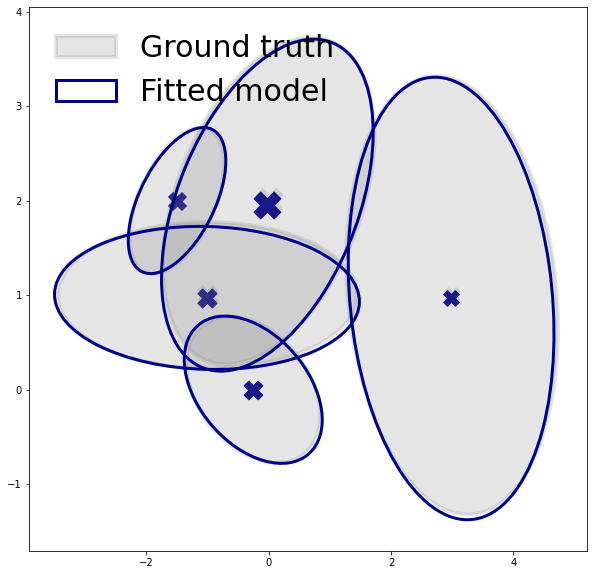

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_covariance(gmm_true.means_, gmm_true.covariances_, gmm_true.weights_, best_fitted_GMM.means_, best_fitted_GMM.covariances_, best_fitted_GMM.weights_)

In [84]:
final_MI_value = estimate_MI_single_posterior_sample(best_fitted_GMM, MC_samples=1e5)
print(final_MI_value)

0.1861819315866808


### Now we bootstrap the samples and fit it; we will check the width of the resulting distribution

In [85]:
X_all_flat = np.reshape(X_all, (-1, 2))
bootstrap_samples = 500
MI_estimates = np.zeros(bootstrap_samples)
MC_samples = 1e5

w_init, m_init, c_init, p_init = initialize_parameters(X_all_flat, best_seed)

# bootstrap available samples
for i in range(bootstrap_samples):
    rng = np.random.default_rng()
    X_bs = rng.choice(X_all_flat, X_all_flat.shape[0])
    gmm = GMM(n_components=n_components, n_init=1, tol=tol, max_iter=10000, 
              random_state=best_seed, weights_init=w_init, 
                 means_init=m_init, precisions_init=p_init).fit(X_bs)

    current_MI_estimate = estimate_MI_single_posterior_sample(gmm, MC_samples=MC_samples)
    MI_estimates[i] = current_MI_estimate #- true_MI_analytical

print(np.mean(MI_estimates), np.std(MI_estimates))

0.1870688416470206 0.005130370143405336


In [58]:
np.std(MI_values_sd[MI_values_sd>0.15])

0.005167533881720873

In [86]:
MI_values_sd = np.load("./MI_values_sd_D5'.npy")

0.010565333193563398
0.01138113897972165


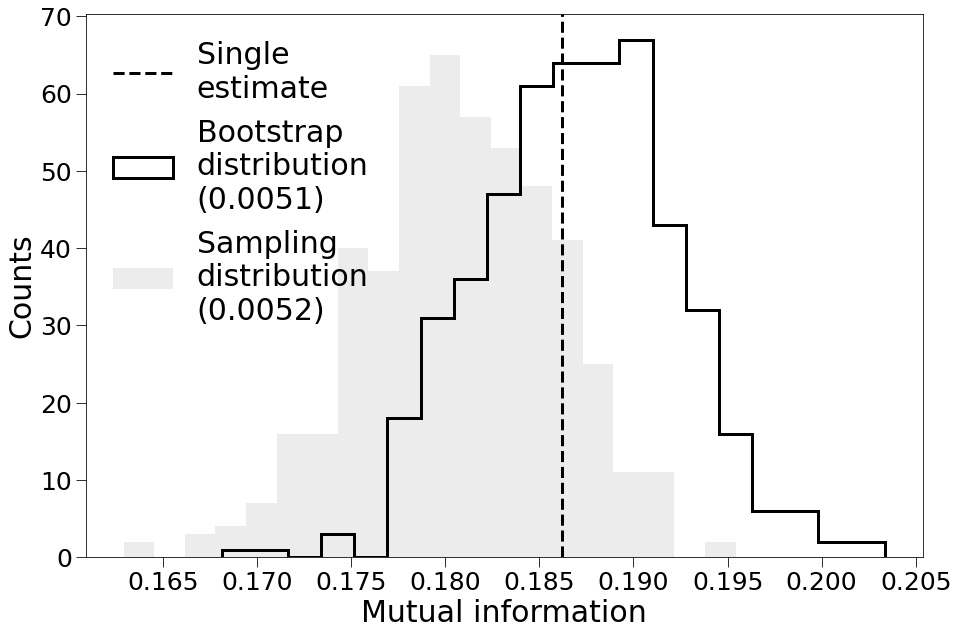

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
bins = 20
density = False

def FWHM(x, y):
    max_y = max(y)  # Find the maximum y value
    #print((len(x)))
    xs = [x_ for x_ in range(len(x)) if y[x_] > max_y/2.0]
    print(np.abs(x[min(xs)] - x[max(xs)])) # Print the points at half-maximum
    
MI_values_sd = np.array(MI_values_sd)
counts, values, _ = ax.hist(MI_estimates, histtype='step',  color='k', lw=3, bins=bins,  label=f'Bootstrap\ndistribution\n({np.std(MI_estimates):.4f})', density=density)
FWHM((values[1:] + values[:-1]) / 2, counts)
ax.axvline(final_MI_value, color='k', linewidth=3, linestyle='--', label='Single\nestimate')
counts, values, _ = ax.hist(MI_values_sd[MI_values_sd>0.15], alpha=0.15, color='grey', lw=3, bins=bins, label=f'Sampling\ndistribution\n({np.std(MI_values_sd[MI_values_sd>0.15]):.4f})', density=density)
FWHM((values[1:] + values[:-1]) / 2, counts)
#ax.axvline(final_MI_value_4, color='k', linewidth=3, linestyle='--')
#ax.axvline(final_MI_value_5, color='k', linewidth=3, linestyle='--')

#ax.set_title("D5'", fontsize=30)

ax.set_xlabel('Mutual information', fontsize=30)
ax.set_ylabel('Counts', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25, size=10)
ax.tick_params(axis='both', which='minor', labelsize=25, size=3)
ax.legend(frameon=False, fontsize=30, loc='upper left');

#ax.set_xlim((0.153, 0.189))
#plt.arrow(0.127, 20, 0, -10, head_width=0.003, head_length=4, color='salmon');

### Sampling distribution, including test to assess value of residual C

In [42]:
n_inits = 10
n_folds = 5
N = int(1e4)
data_each_fold = N // n_folds
tol = 1e-6
reg_covar = 1e-6
X_all = np.zeros((n_folds, data_each_fold, 2))

# number of components is fixed to the true number
reps = 500
MI_values_sd = []
C_values = []

# first, sample training and validation data
# this is a mixture of training and validation, since we do m-fold CV
for rep in range(reps):
    val_scores_seeds = np.zeros((n_inits, 2))

    for i in range(n_folds):
        gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=i+rep*10)
        X_all[i] = gmm_true.sample(data_each_fold)[0]

    X_all_flat = np.reshape(X_all, (-1, 2))

    # fix the random seed first
    for r, init in enumerate(range(n_inits)):

        w_init, m_init, c_init, p_init = initialize_parameters(X_all_flat, r)
        validation_scores = []
        for fold in range(n_folds):
            X_validation = X_all[fold].reshape(data_each_fold, 2)
            X_training = X_all[np.arange(len(X_all))!=fold].reshape(-1, 2)

            fitted_gmm = GMM(n_components=n_components, reg_covar=reg_covar, 
                             init_params='random', tol=tol, max_iter=10000, 
                             random_state=r, weights_init=w_init, 
                             means_init=m_init, precisions_init=p_init).fit(X_training)

            val_score = fitted_gmm.score_samples(X_validation).mean()
            validation_scores.append(np.copy(val_score))
            #if r == 19 and fold == 1:
                #fig, ax = plt.subplots(1, 1, figsize=(10, 10))
                #print(fitted_gmm.weights_)
                #plot_covariance(gmm_true.means_, gmm_true.covariances_, gmm_true.weights_, fitted_gmm.means_, fitted_gmm.covariances_, fitted_gmm.weights_)

        # take mean and std dev of current seed's val scores
        val_scores_seeds[r, :] = np.mean(validation_scores), np.sqrt(np.var(validation_scores, ddof=1)/(n_folds-1))

    # select seed with highest val score
    best_seed = np.argmax(val_scores_seeds[:, 0])

    X_all_flat = np.reshape(X_all, (-1, 2))

    w_init, m_init, c_init, p_init = initialize_parameters(X_all_flat, best_seed)

    best_fitted_GMM = GMM(n_components=n_components, reg_covar=reg_covar, 
                     init_params='random', tol=tol, max_iter=10000, 
                     random_state=best_seed, weights_init=w_init, 
                     means_init=m_init, precisions_init=p_init).fit(X_all_flat)
    
    # calculate performance on all data of the final fitted model, and compare it to the performance on validation data
    final_ll_score = best_fitted_GMM.score_samples(X_all_flat).mean()
    C = (final_ll_score - val_scores_seeds[best_seed, 0]) / val_scores_seeds[best_seed, 1]
    C_values.append(C)
    
    final_MI_values = estimate_MI_single_posterior_sample(best_fitted_GMM, MC_samples=1e5)
    print(final_MI_values)
    MI_values_sd.append(final_MI_values)

0.17765829341173842
0.1868668649922703
0.19152090228782162
0.17200012096444858
0.1847105141465143
0.18823724310850648
0.18096401041110258
0.17934232436519684
0.17532297864102914
0.1663559954009316
0.17558163896854018
0.19089048616653642
0.18644679855555119
0.18294957221465036
0.1836167803626274
0.18030267479476178
0.18441717236102126
0.18779583774822542
0.1761298037172035
0.17812726639503962
0.17877361475068768
0.18509398359734971
0.17581209388430163
0.18197749290345466
0.17973761265684163
0.177681138195972
0.18005922809256616
0.18024130703749655
0.16328084996678843
0.17171619379290706
0.18500328042745837
0.17914032650376957
0.17208874428483695
0.1735970447042357
0.18002646886854842
0.16711609402580613
0.1792722095744275
0.18612292927936291
0.18255704007207382
0.18377364248321504
0.17167642386654708
0.18531676605888184
0.1789989687746637
0.17844655308204402
0.18168433034351558
0.1829202194975348
0.1713379545762486
0.17947650761553696
0.1885472613409247
0.18071882487179494
0.18527788634

0.1778045267828299
0.1810481238710181
0.18818690253647993
0.1848700881934307
0.17608553367057017
0.17846386202010056
0.18523721984454233
0.17927801817019506
0.17370237337689573
0.18065144256659024
0.18388488190479738
0.1868015176832864
0.18418422545198707
0.1901814134946877
0.19105210010148188
0.17604951660750143
0.17893086610757705
0.18123104586206004
0.18308667726650552
0.18721864062126228
0.17488508085971535
0.17134439536117238
0.1872293628459958
0.18319596891581022
0.18887297895523728
0.18514157463893177
0.1766924004737921
0.17903648649758083
0.1812377469611081
0.1767368580169967
0.17355729427358998
0.17670036164738911
0.17874810731127108
0.1774895416954449
0.18249831863542673
0.1810539842811735
0.1807523490923211
0.17289979236001163
0.18352115882721998
0.18104735312188547
0.17812671430105786
0.17460470454458865
0.17920503467315568
0.18645893294201907
0.1817788411086472
0.17946542754025807
0.1853599227671766
0.17641411574262536
0.17336125521432055
0.184413286490102
0.16977093745019

In [43]:
np.save("./C_values_D5'", C_values) 

In [8]:
MI_values_sd = np.load("./MI_values_sd_D5'.npy")

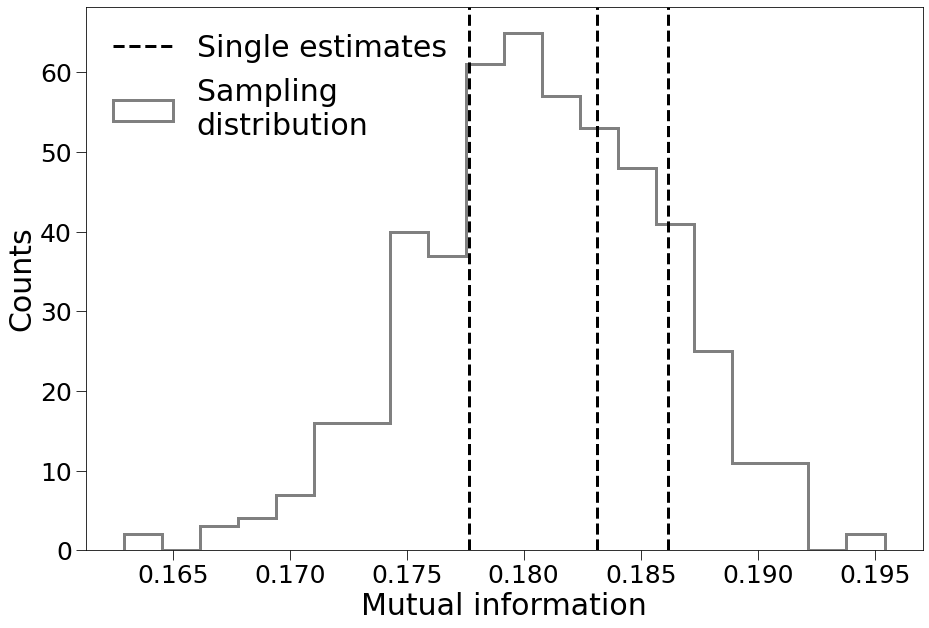

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
bins = 20

MI_values_sd = np.array(MI_values_sd)
ax.hist(MI_values_sd[MI_values_sd>0.15], histtype='step', color='grey', lw=3, bins=bins, label='Sampling\ndistribution')
ax.axvline(final_MI_value, color='k', linewidth=3, linestyle='--', label='Single estimates')
ax.axvline(final_MI_value_4, color='k', linewidth=3, linestyle='--')
ax.axvline(final_MI_value_5, color='k', linewidth=3, linestyle='--')

#ax.set_title("D5'", fontsize=30)

ax.set_xlabel('Mutual information', fontsize=30)
ax.set_ylabel('Counts', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25, size=10)
ax.tick_params(axis='both', which='minor', labelsize=25, size=3)
ax.legend(frameon=False, fontsize=30, loc='upper left');

#plt.arrow(0.127, 20, 0, -10, head_width=0.003, head_length=4, color='salmon');

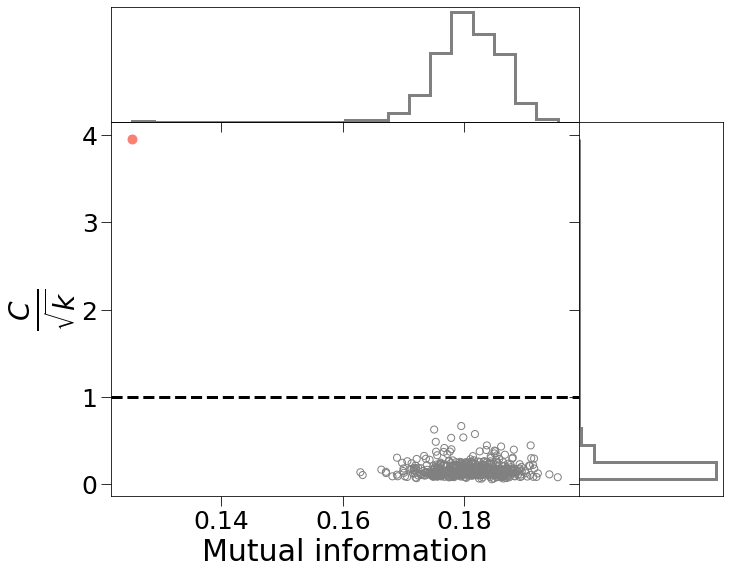

In [72]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, s=50, facecolors='None', edgecolors='grey')

    # now determine nice limits by hand:
    binwidth = 1
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=20, histtype='step', lw=3, color='grey')
    ax_histy.hist(y, bins=20, orientation='horizontal', histtype='step', lw=3, color='grey')
    #ax.set_yscale('log')
    
fig = plt.figure(figsize=(10, 8))

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.00


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
# the values of C are wrong, since we should have used n_folds instead of n_folds-1
C_values = np.array(C_values)
scatter_hist(MI_values_sd, np.abs(C_values)/np.sqrt(n_folds-1) , ax, ax_histx, ax_histy)
ax.scatter(MI_values_sd[MI_values_sd<0.15], np.abs(C_values[ C_values < -2]) /np.sqrt(n_folds-1), c='salmon', s=80)
ax.set_xlabel('Mutual information', fontsize=30)
ax.set_ylabel(r'$\frac{C}{\sqrt{k}}$', fontsize=40)

ax.axhline(1, lw=3, c='k', ls='--')

ax.tick_params(axis='both', which='major', labelsize=25, size=10)
ax.tick_params(axis='both', which='minor', labelsize=25, size=3)
ax_histx.tick_params(axis='both', which='both', labelsize=25, size=10)
ax_histx.get_yaxis().set_visible(False)
ax_histy.tick_params(axis='both', which='both', labelsize=25, size=10)
ax_histy.get_xaxis().set_visible(False)

#ax.set_yticks([-3, -2, -1, 0, 1])
#ax.set_yticklabels([0.001, 0.01, 0.1, 1, 10]);

array([-7.90726072])

### Finally, also look at the error induced by the finite number of MC samples

In [46]:
random_states = np.arange(500)
MC_samples = 1e4
MC_dist_1e4 = []

for random_state in random_states:
    gmm = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=random_state)
    current_MI = estimate_MI_single_posterior_sample(gmm, MC_samples=MC_samples)
    MC_dist_1e4.append(current_MI)

In [47]:
random_states = np.arange(500)
MC_samples = 1e5
MC_dist_1e5 = []

for random_state in random_states:
    gmm = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=random_state)
    current_MI = estimate_MI_single_posterior_sample(gmm, MC_samples=MC_samples)
    MC_dist_1e5.append(current_MI)

In [48]:
random_states = np.arange(500)
MC_samples = 1e6
MC_dist_1e6 = []

for random_state in random_states:
    gmm = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=random_state)
    current_MI = estimate_MI_single_posterior_sample(gmm, MC_samples=MC_samples)
    MC_dist_1e6.append(current_MI)

In [49]:
# here we define a custom model for a fixed gmm with known parameters
class FixedParMixture_:
    """ A model to estimate gaussian mixture with fixed parameters matrix. 
        This is only needed to estimate its log-likelihood, not to sample from it
        Note this is only for a 1D GMM, as in n_features=1! 
    """
    def __init__(self, n_components, mean, cov, weight):
        self.n_components = n_components
        self.mean = mean
        self.cov = cov
        self.w = weight

    
    def estimate_prob(self, X):
        marginal = 0
        for i in range(self.n_components):
            mu = self.mean[i]
            sigma = self.cov[i]
            w = self.w[i]
            marginal += w*multivariate_normal.pdf(x=np.array([X]).T, mean=np.array([mu]), cov=np.array([sigma]))         
        return marginal
        
    
    def score_samples(self, X):
        """Compute the log-likelihood of each sample.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log-likelihood of each sample in `X` under the current model.
            
        This is taken from the sklearn source code
        """

        return np.log(self.estimate_prob(X))

def marginal_loglike_x(gmm, x):
    # i = 0 is x
    # i = 1 is y
    X = np.array(x).reshape(-1, 1)
    #X = np.concatenate((y.reshape(1, 1), x.reshape(1, 1))).T
    #print(X)
    ll = FixedParMixture_(n_components, gmm.means_[:, 0], gmm.covariances_[:, 0, 0], gmm.weights_).score_samples(X[:, 0])
    return ll

def marginal_loglike_y(gmm, x):
    # i = 0 is x
    # i = 1 is y
    X = np.array(x).reshape(-1, 1)
    #X = np.concatenate((y.reshape(1, 1), x.reshape(1, 1))).T
    #print(X)
    ll = FixedParMixture_(n_components, gmm.means_[:, 1], gmm.covariances_[:, 1, 1], gmm.weights_).score_samples(X[:, 0])
    return ll

def marginal_loglike_(gmm, i, x, y):
    # i = 0 is x
    # i = 1 is y
    y = np.array(y)
    x = np.array(x)
    X = np.concatenate((y.reshape(1, 1), x.reshape(1, 1))).T
    ll = FixedParMixture_(n_components, gmm.means_[:, i], gmm.covariances_[:, i, i], gmm.weights_).score_samples(X[:, i])
    return ll


# let's do some numerical integration first
def logp(y, x, model):
    y = np.array(y)
    x = np.array(x)
    X = np.concatenate((y.reshape(1, 1), x.reshape(1, 1))).T
    return model.score_samples(X)

def p(y, x):
    return np.exp(logp(y, x))

def integrand(y, x, model=gmm_true):
    logp_ = logp(y, x, model)
    p_ = np.exp(logp_)
    return p_*logp_

def integrand_x(x, model=gmm_true):
    logp_x = marginal_loglike_x(model, x)
    #print(logp_x)
    p_x = np.exp(logp_x)
    if np.abs(logp_x) == np.inf:
        return 0
    return p_x*logp_x

def integrand_y(x, model=gmm_true):
    logp_x = marginal_loglike_y(model, x)
    #print(logp_x)
    p_x = np.exp(logp_x)
    if np.abs(logp_x) == np.inf:
        return 0
    return p_x*logp_x

tolint = 1e-12
limit = np.inf

def estimate_MI_single_posterior_sample_int(gmm):
    
    MI_2 = integrate.quad(integrand_x, -limit, limit, args=(gmm))[0]
    MI_3 = integrate.quad(integrand_y, -limit, limit, args=(gmm))[0]    
    MI_1 = integrate.dblquad(integrand, -limit, limit, lambda x: -limit, lambda x: limit, args=[gmm])[0]

    return MI_1 - MI_2 - MI_3

In [50]:
true_MI = estimate_MI_single_posterior_sample_int(gmm_true)

/home/dpiras/.conda/envs/MI/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log


In [51]:
true_MI

0.1797219348443444

0.003877642794668762
0.0008612147603890841


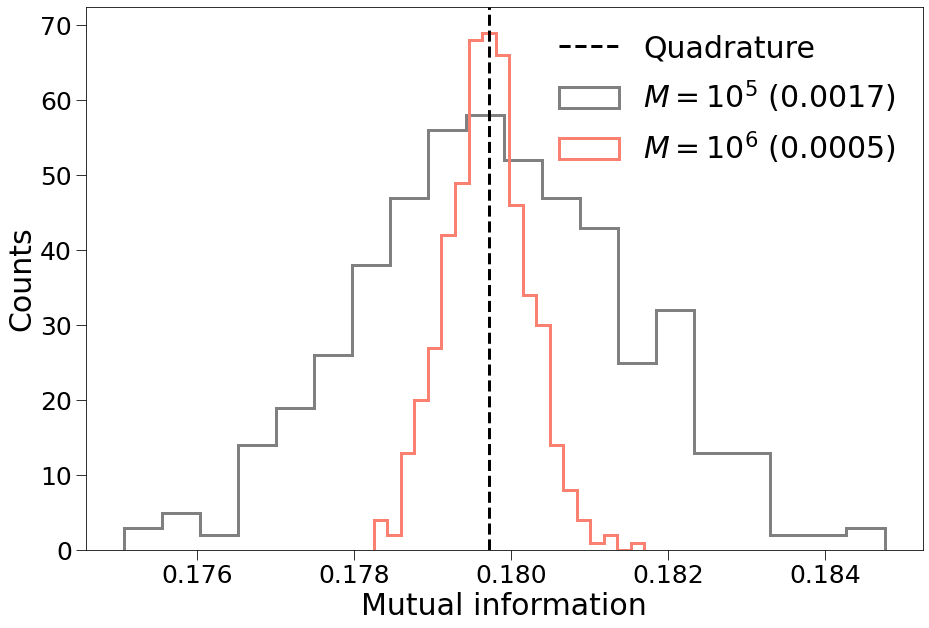

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
bins = 20

def FWHM(x, y):
    max_y = max(y)  # Find the maximum y value
    #print((len(x)))
    xs = [x_ for x_ in range(len(x)) if y[x_] > max_y/2.0]
    print(np.abs(x[min(xs)] - x[max(xs)])) # Print the points at half-maximum
    
    
#MI_values_sd = np.array(MI_values_sd)
#ax.hist(MC_dist_1e4, histtype='step', color='black', lw=3, bins=bins, label='$M = 10^4$')
counts, values, _ = ax.hist(MC_dist_1e5, histtype='step', color='grey', lw=3, bins=bins, label=f'$M = 10^5$ ({np.std(MC_dist_1e5):.4f})')
FWHM((values[1:] + values[:-1]) / 2, counts)

counts, values, _ = ax.hist(MC_dist_1e6, histtype='step', color='salmon', lw=3, bins=bins, label=f'$M = 10^6$ ({np.std(MC_dist_1e6):.4f})')
FWHM((values[1:] + values[:-1]) / 2, counts)

ax.axvline(true_MI, color='k', linewidth=3, linestyle='--', label='Quadrature')
#ax.axvline(final_MI_value_4, color='k', linewidth=3, linestyle='--')
#ax.axvline(final_MI_value_5, color='k', linewidth=3, linestyle='--')

#ax.set_title("D5'", fontsize=30)

ax.set_xlabel('Mutual information', fontsize=30)
ax.set_ylabel('Counts', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25, size=10)
ax.tick_params(axis='both', which='minor', labelsize=25, size=3)
ax.legend(frameon=False, fontsize=30, loc='upper right');

#plt.arrow(0.127, 20, 0, -10, head_width=0.003, head_length=4, color='salmon');

In [53]:
np.save("./MC_1e5_values_D5'", MC_dist_1e5)
np.save("./MC_1e6_values_D5'", MC_dist_1e6)

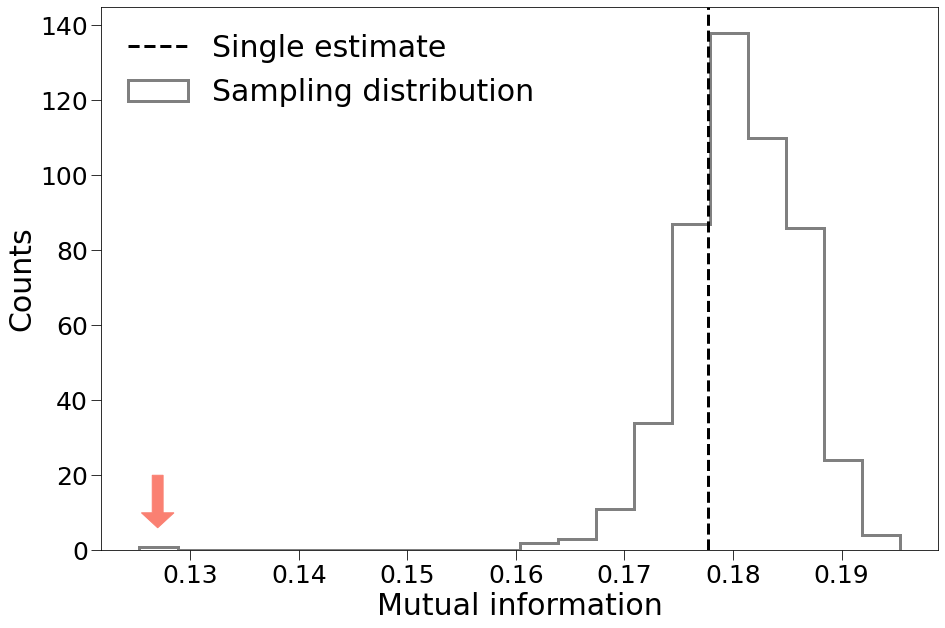

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
bins = 20

ax.hist(MI_values_sd, histtype='step', color='grey', lw=3, bins=bins, label='Sampling distribution')
ax.axvline(final_MI_value, color='k', linewidth=3, linestyle='--', label='Single estimate')

#ax.set_title("D5'", fontsize=30)

ax.set_xlabel('Mutual information', fontsize=30)
ax.set_ylabel('Counts', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25, size=10)
ax.tick_params(axis='both', which='minor', labelsize=25, size=3)
ax.legend(frameon=False, fontsize=30, loc='upper left')

plt.arrow(0.127, 20, 0, -10, head_width=0.003, head_length=4, color='salmon');

In [10]:
#np.save("./MI_values_sd_D5'", MI_values_sd)
MI_values_sd = np.load("./MI_values_sd_D5'.npy")

In [11]:
np.argwhere(np.array(MI_values_sd) < 0.15)

array([[95]])

In [12]:
MI_values_sd[95]

0.1253245963348787

In [13]:
n_inits = 10
n_folds = 5
N = int(1e4)
data_each_fold = N // n_folds
tol = 1e-6
reg_covar = 1e-6
val_scores_seeds = np.zeros(n_inits)

X_all = np.zeros((n_folds, data_each_fold, 2))

# number of components is fixed to the true number
reps = 500
MI_values_sd_ = []

# first, sample training and validation data
# this is a mixture of training and validation, since we do m-fold CV
for rep in range(95, 96):
    
    for i in range(n_folds):
        gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=i+rep*10)
        X_all[i] = gmm_true.sample(data_each_fold)[0]

    X_all_flat = np.reshape(X_all, (-1, 2))
    
    validation_scores_ = []

    # fix the random seed first
    for r, init in enumerate(range(n_inits)):

        w_init, m_init, c_init, p_init = initialize_parameters(X_all_flat, r)
        validation_scores = []

        for fold in range(n_folds):
            X_validation = X_all[fold].reshape(data_each_fold, 2)
            X_training = X_all[np.arange(len(X_all))!=fold].reshape(-1, 2)

            fitted_gmm = GMM(n_components=n_components, reg_covar=reg_covar, 
                             init_params='random', tol=tol, max_iter=10000, 
                             random_state=r, weights_init=w_init, 
                             means_init=m_init, precisions_init=p_init).fit(X_training)

            val_score = fitted_gmm.score_samples(X_validation).sum()
            #print(val_score)
            if r == 8:            
                val_score = fitted_gmm.score_samples(X_validation).mean()
                print(val_score)
                validation_scores_.append(val_score)
                #fig, ax = plt.subplots(1, 1, figsize=(10, 10))
                #plot_covariance(gmm_true.means_, gmm_true.covariances_, gmm_true.weights_, fitted_gmm.means_, fitted_gmm.covariances_, fitted_gmm.weights_)

                
                
            validation_scores.append(np.copy(val_score))
            #if r == 19 and fold == 1:
                #fig, ax = plt.subplots(1, 1, figsize=(10, 10))
                #print(fitted_gmm.weights_)
                #plot_covariance(gmm_true.means_, gmm_true.covariances_, gmm_true.weights_, fitted_gmm.means_, fitted_gmm.covariances_, fitted_gmm.weights_)

        # take mean of current seed's val scores
        val_scores_seeds[r] = np.mean(validation_scores)
        print()

    print(np.mean(validation_scores_), np.std(validation_scores_)) 
    # select seed with highest val score
    best_seed = np.argmax(val_scores_seeds)

    X_all_flat = np.reshape(X_all, (-1, 2))

    w_init, m_init, c_init, p_init = initialize_parameters(X_all_flat, best_seed)

    best_fitted_GMM = GMM(n_components=n_components, reg_covar=reg_covar, 
                     init_params='random', tol=tol, max_iter=10000, 
                     random_state=best_seed, weights_init=w_init, 
                     means_init=m_init, precisions_init=p_init).fit(X_all_flat)

    val_score = best_fitted_GMM.score_samples(X_all_flat).mean()
    print(val_score) 
    
    print((np.mean(validation_scores_) - val_score)/ np.std(validation_scores_) )
    
    final_MI_values = estimate_MI_single_posterior_sample(best_fitted_GMM, MC_samples=1e5)
    print(final_MI_values, best_fitted_GMM.score_samples(X_validation).sum(), best_seed)
    MI_values_sd_.append(final_MI_values)









-2.759514330648509
-2.761801725732259
-2.791517689090812
-2.760920597087189
-2.7857509368183533


-2.771901055875424 0.013803111295851047
-2.8329148537641244
4.4202931194969075
0.1253245963348787 -5683.479338425301 8


In [8]:
best_seed

4

In [31]:
val_scores_seeds

array([-5543.93335531, -5543.98586042, -5543.98172609, -5543.97936535,
       -5543.81460147, -5543.98252943, -5543.97976749, -5543.9834213 ,
       -5543.80211175, -5544.00064058, -5544.0731898 , -5543.98434951,
       -5544.00758292, -5543.95148312, -5543.98307301, -5543.98858595,
       -5544.24393446, -5543.98227606, -5544.25903721, -5543.97735075,
       -5544.03276245, -5543.98108092, -5543.9771662 , -5543.98365811,
       -5543.97966532, -5543.87490475, -5543.98349463, -5543.97880303,
       -5543.97866057, -5573.92559223])

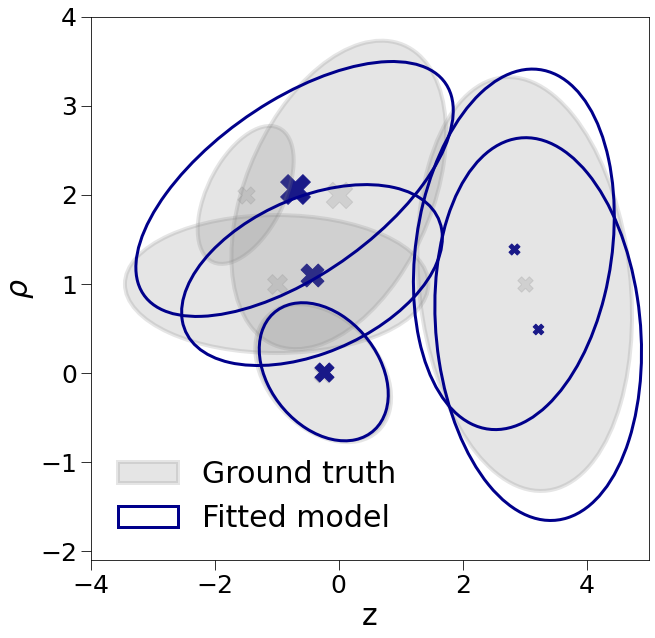

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_covariance(gmm_true.means_, gmm_true.covariances_, gmm_true.weights_, best_fitted_GMM.means_, best_fitted_GMM.covariances_, best_fitted_GMM.weights_)

ax.set_xlabel('z', fontsize=30)
ax.set_ylabel(r'$\rho$', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25, size=10)
ax.tick_params(axis='both', which='minor', labelsize=25, size=3)

ax.set_xlim((-4, 5))
ax.set_ylim((-2.1, 4));
    
#ax.legend(frameon=False, fontsize=30, loc='upper left');

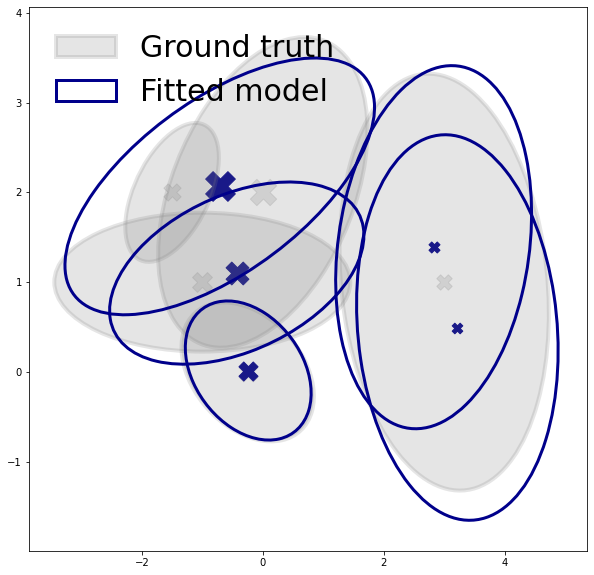

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_covariance(gmm_true.means_, gmm_true.covariances_, gmm_true.weights_, best_fitted_GMM.means_, best_fitted_GMM.covariances_, best_fitted_GMM.weights_)

### Aside about calculating MI with direct numerical integration (no MC)

In [19]:
tic = time.time()
estimate_MI_single_posterior_sample(best_fitted_GMM, MC_samples=1e6)
print(time.time()-tic)

1.1526083946228027


In [92]:
# here we define a custom model for a fixed gmm with known parameters
class FixedParMixture_:
    """ A model to estimate gaussian mixture with fixed parameters matrix. 
        This is only needed to estimate its log-likelihood, not to sample from it
        Note this is only for a 1D GMM, as in n_features=1! 
    """
    def __init__(self, n_components, mean, cov, weight):
        self.n_components = n_components
        self.mean = mean
        self.cov = cov
        self.w = weight

    
    def estimate_prob(self, X):
        marginal = 0
        for i in range(self.n_components):
            mu = self.mean[i]
            sigma = self.cov[i]
            w = self.w[i]
            marginal += w*multivariate_normal.pdf(x=np.array([X]).T, mean=np.array([mu]), cov=np.array([sigma]))         
        return marginal
        
    
    def score_samples(self, X):
        """Compute the log-likelihood of each sample.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log-likelihood of each sample in `X` under the current model.
            
        This is taken from the sklearn source code
        """

        return np.log(self.estimate_prob(X))

def marginal_loglike_x(gmm, x):
    # i = 0 is x
    # i = 1 is y
    X = np.array(x).reshape(-1, 1)
    #X = np.concatenate((y.reshape(1, 1), x.reshape(1, 1))).T
    #print(X)
    ll = FixedParMixture_(n_components, gmm.means_[:, 0], gmm.covariances_[:, 0, 0], gmm.weights_).score_samples(X[:, 0])
    return ll

def marginal_loglike_y(gmm, x):
    # i = 0 is x
    # i = 1 is y
    X = np.array(x).reshape(-1, 1)
    #X = np.concatenate((y.reshape(1, 1), x.reshape(1, 1))).T
    #print(X)
    ll = FixedParMixture_(n_components, gmm.means_[:, 1], gmm.covariances_[:, 1, 1], gmm.weights_).score_samples(X[:, 0])
    return ll

def marginal_loglike_(gmm, i, x, y):
    # i = 0 is x
    # i = 1 is y
    y = np.array(y)
    x = np.array(x)
    X = np.concatenate((y.reshape(1, 1), x.reshape(1, 1))).T
    ll = FixedParMixture_(n_components, gmm.means_[:, i], gmm.covariances_[:, i, i], gmm.weights_).score_samples(X[:, i])
    return ll


# let's do some numerical integration first
def logp(y, x, model):
    y = np.array(y)
    x = np.array(x)
    X = np.concatenate((y.reshape(1, 1), x.reshape(1, 1))).T
    return model.score_samples(X)

def p(y, x):
    return np.exp(logp(y, x))

def integrand(y, x, model=gmm_true):
    logp_ = logp(y, x, model)
    p_ = np.exp(logp_)
    return p_*logp_

def integrand_x(x, model=gmm_true):
    logp_x = marginal_loglike_x(model, x)
    #print(logp_x)
    p_x = np.exp(logp_x)
    if np.abs(logp_x) == np.inf:
        return 0
    return p_x*logp_x

def integrand_y(x, model=gmm_true):
    logp_x = marginal_loglike_y(model, x)
    #print(logp_x)
    p_x = np.exp(logp_x)
    if np.abs(logp_x) == np.inf:
        return 0
    return p_x*logp_x

tolint = 1e-12
limit = 10#np.inf

def estimate_MI_single_posterior_sample_int(gmm):
    
    MI_2 = integrate.quad(integrand_x, -limit, limit, args=(gmm))[0]
    MI_3 = integrate.quad(integrand_y, -limit, limit, args=(gmm))[0]    
    MI_1 = integrate.dblquad(integrand, -limit, limit, lambda x: -limit, lambda x: limit, args=[gmm])[0]

    return MI_1 - MI_2 - MI_3

In [93]:
tic = time.time()
print(estimate_MI_single_posterior_sample_int(best_fitted_GMM))
print(time.time()-tic)

0.184416447883186
32.06782531738281


In [89]:
estimate_MI_single_posterior_sample(best_fitted_GMM, MC_samples=1e6)

0.1850445226895004

In [48]:
MI_values_sd = np.load("./D5'_C_MI.npy")

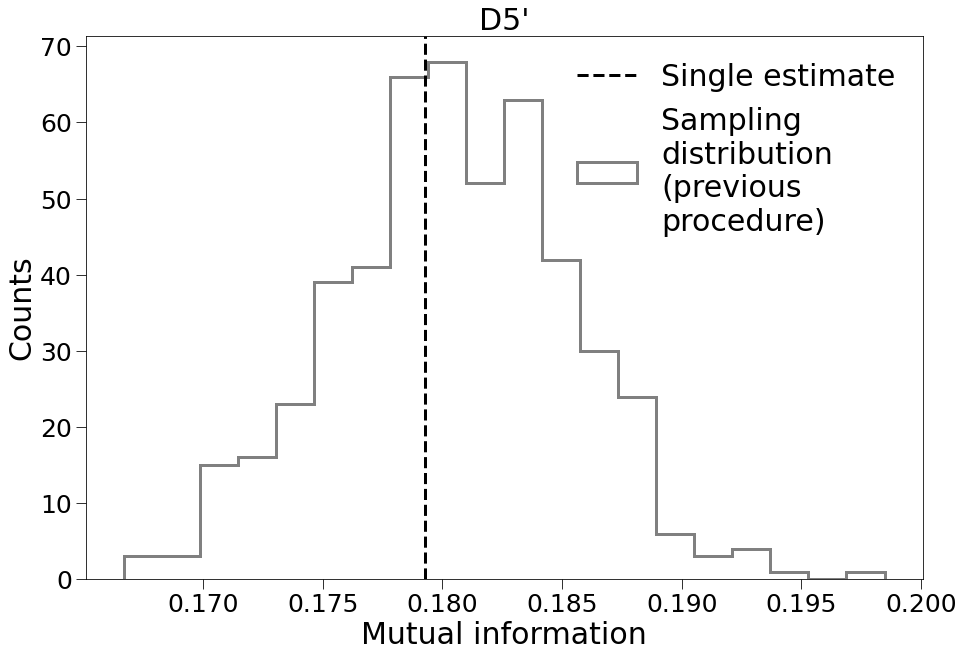

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
bins = 20

ax.hist(MI_values_sd[4, :, 0], histtype='step', bins=bins, color='grey', lw=3, label='Sampling\ndistribution\n(previous\nprocedure)')
ax.axvline(final_MI_value, color='k', linewidth=3, linestyle='--', label='Single estimate')

ax.set_title("D5'", fontsize=30)

ax.set_xlabel('Mutual information', fontsize=30)
ax.set_ylabel('Counts', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25, size=10)
ax.tick_params(axis='both', which='minor', labelsize=25, size=3)
ax.legend(frameon=False, fontsize=30, loc='upper right');

### check if it ever fails

In [27]:
n_inits = 20
n_folds = 5
N = int(1e4)
data_each_fold = N // n_folds
tol = 1e-6
reg_covar = 1e-6
val_scores_seeds = np.zeros(n_inits)

X_all = np.zeros((n_folds, data_each_fold, 2))

# first, sample training and validation data
# this is a mixture of training and validation, since we do m-fold CV
reps = 1000
MI_values = []

for rep in range(reps):
    for i in range(n_folds):
        gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=i+rep*10)
        X_all[i] = gmm_true.sample(data_each_fold)[0]

    # number of components is fixed to the true number

    # fix the random seed first
    for r, init in enumerate(range(n_inits)):

        #print()  
        validation_scores = []
        for fold in range(n_folds):
            X_validation = X_all[fold].reshape(data_each_fold, 2)
            X_training = X_all[np.arange(len(X_all))!=fold].reshape(-1, 2)

            fitted_gmm = GMM(n_components=n_components, reg_covar=reg_covar, 
                             init_params='random', tol=tol, max_iter=10000, 
                             random_state=r).fit(X_training)

            val_score = fitted_gmm.score_samples(X_validation).sum()
            #print(val_score)
            validation_scores.append(np.copy(val_score))
            #if r == 19 and fold == 1:
                #fig, ax = plt.subplots(1, 1, figsize=(10, 10))
                #print(fitted_gmm.weights_)
                #plot_covariance(gmm_true.means_, gmm_true.covariances_, gmm_true.weights_, fitted_gmm.means_, fitted_gmm.covariances_, fitted_gmm.weights_)

        # take mean of current seed's val scores
        val_scores_seeds[r] = np.mean(validation_scores)
        #print()



    # select seed with highest val score
    best_seed = np.argmax(val_scores_seeds)

    X_all_flat = np.reshape(X_all, (-1, 2))

    best_fitted_GMM = GMM(n_components=n_components, reg_covar=reg_covar, 
                     init_params='random', tol=tol, max_iter=10000, 
                     random_state=best_seed).fit(X_all_flat)
    
    final_MI_values = estimate_MI_single_posterior_sample(best_fitted_GMM, MC_samples=1e5)
    print(final_MI_values)
    MI_values.append(final_MI_values)

0.1792660849374158
0.18181652212736413
0.19251081315918916
0.17200012096444892
0.18471051414651599
0.19174431675263381
0.18054245472909342
0.17975369176562336
0.12888794796101274
0.169307963703488
0.17732342566093925
0.18879507045129415
0.1875699234150432
0.18316262343050468
0.18285250995071572
0.1838151579488815
0.18376332256075065
0.18588112278873356
0.17387245761493816
0.18313576674203355
0.18474409951142257
0.18860611871826652
0.17373265086079454
0.18276060921652362
0.17872638339306385
0.18148976427651212
0.1805535810235886
0.1792873026311257
0.16427435470982638
0.17334123977899912
0.1829937531755499
0.17999467595697566
0.17259152907864586
0.17071901801537126
0.17862096831095964
0.1690658492985719
0.17723484094170286
0.18527148459243784
0.18229125920833375
0.18377364248321373
0.1770052952789229
0.18658269632795
0.1783337574188714
0.178446553082045
0.18315036219804978
0.18468532643856167
0.1705932814443662
0.18144962055555422
0.1905947113740816
0.1803925759994539
0.18773173079279715

KeyboardInterrupt: 

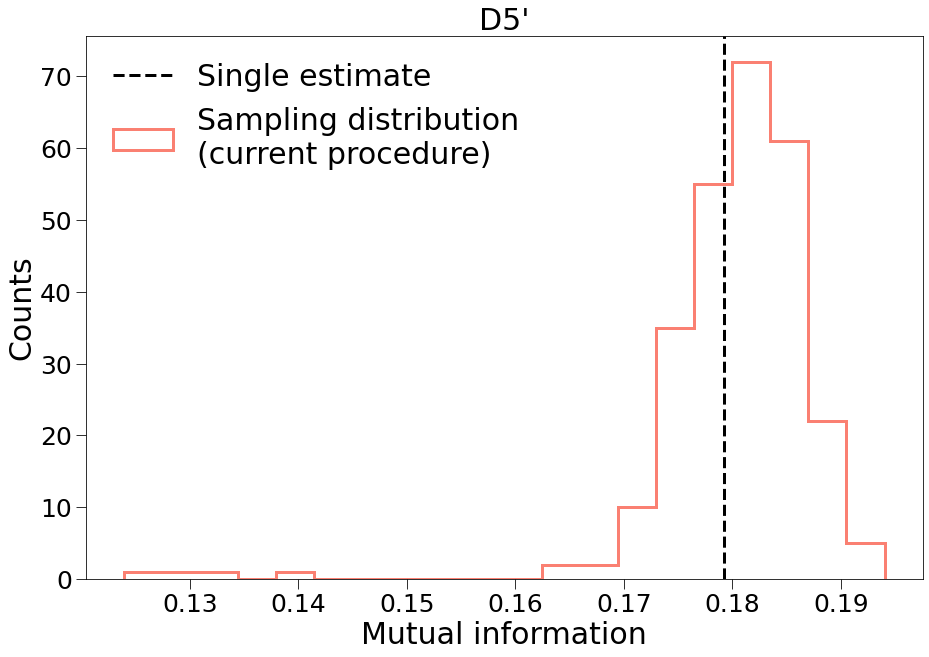

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
bins = 20

ax.hist(MI_values_copy, histtype='step', color='salmon', lw=3, bins=bins, label='Sampling distribution\n(current procedure)')
ax.axvline(final_MI_value, color='k', linewidth=3, linestyle='--', label='Single estimate')

ax.set_title("D5'", fontsize=30)

ax.set_xlabel('Mutual information', fontsize=30)
ax.set_ylabel('Counts', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25, size=10)
ax.tick_params(axis='both', which='minor', labelsize=25, size=3)
ax.legend(frameon=False, fontsize=30, loc='upper left');

In [32]:
len(np.array(MI_values) < 0.15)

268

In [34]:
(np.array(MI_values) < 0.15).sum()

4

In [36]:
MI_values_copy = np.copy(MI_values)

### Small test

In [130]:
n_inits = 10
n_folds = 5
N = int(1e4)
data_each_fold = N // n_folds
tol = 1e-6
reg_covar = 1e-6
val_scores_seeds = np.zeros(n_inits)

X_all = np.zeros((n_folds, data_each_fold, 2))

# number of components is fixed to the true number
reps = 500
MI_values_sd_ = []

# first, sample training and validation data
# this is a mixture of training and validation, since we do m-fold CV
for rep in range(95, 96):
    
    for i in range(n_folds):
        gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=i+rep*10)
        X_all[i] = gmm_true.sample(data_each_fold)[0]

    X_all_flat = np.reshape(X_all, (-1, 2))



    w_init, m_init, c_init, p_init = initialize_parameters(X_all_flat, 8)
    
    #print(initialize_parameters(X_all_flat, best_seed))

    training_data = np.concatenate((X_all_flat[:9978], X_all_flat[9978:]))
    best_fitted_GMM = GMM(n_components=n_components, reg_covar=reg_covar, 
                     tol=1e-6, max_iter=10000, 
                     random_state=best_seed, weights_init=w_init, 
                     means_init=m_init, precisions_init=p_init).fit(training_data)

    val_score = best_fitted_GMM.score_samples(training_data).mean()
    print(val_score)    
    
    final_MI_values = estimate_MI_single_posterior_sample(best_fitted_GMM, MC_samples=1e5)
    print(final_MI_values)

-2.8329148537641244
0.1253245963348787


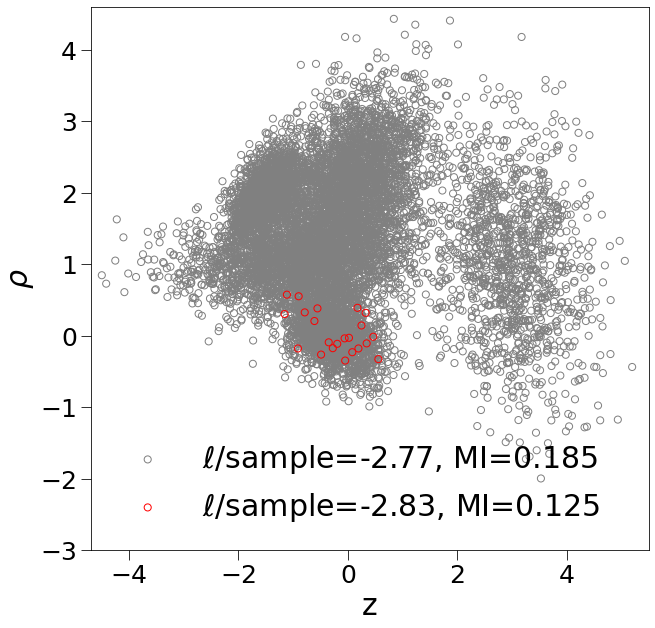

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#plot_covariance(gmm_true.means_, gmm_true.covariances_, gmm_true.weights_, best_fitted_GMM.means_, best_fitted_GMM.covariances_, best_fitted_GMM.weights_)

ax.scatter(X_all_flat[:9978, 0], X_all_flat[:9978, 1], s=50, facecolors='None', edgecolors='grey', label='$\ell$/sample=-2.77, MI=0.185')
ax.scatter(X_all_flat[9978:, 0], X_all_flat[9978:, 1], s=50, facecolors='None', edgecolors='red', label='$\ell$/sample=-2.83, MI=0.125')

ax.set_xlabel('z', fontsize=30)
ax.set_ylabel(r'$\rho$', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25, size=10)
ax.tick_params(axis='both', which='minor', labelsize=25, size=3)

ax.set_xlim((-4.7, 5.5))
ax.set_ylim((-3, 4.6));
    
ax.legend(frameon=False, fontsize=30);

In [91]:
training_data.shape

(9999, 2)

In [ ]:
X_all_flat[:9978]